In [ ]:
import pandas as pd 
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt 
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import os
import time
import math
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')   

Mounted at /content/drive


In [ ]:
data_PATH = r'/content/drive/MyDrive/Datasets/data256/train'
label_PATH = r'/content/drive/MyDrive/Datasets/train.csv'

test_PATH = r'/content/drive/MyDrive/Datasets/data256/test'

submit_PATH = r'/content/drive/MyDrive/Datasets/test.csv'

df_train = pd.read_csv(label_PATH)
df_test = pd.read_csv(submit_PATH)
df_train['label'] = df_train['label'].astype('str')

df_train.head()
df_test.head()

,name,pred
0,test_1000183618656797.png,NaN
1,test_1000393965653244.png,NaN
2,test_100071345206782.png,NaN
3,test_100100998368010.png,NaN
4,test_1001897299647728.png,NaN


# Data (Image Augmentation) Visualization

Text(0.5, 1.0, 'Target')

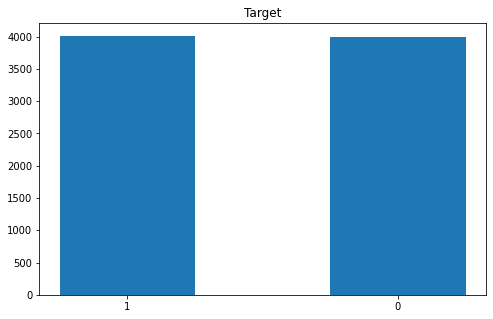

In [ ]:
fig,ax = plt.subplots(figsize=(8,5))
ax.bar(df_train.label.value_counts().index,df_train.label.value_counts().values,width=0.5)
ax.set_title('Target')

Data cân bằng

# Original Picture

Text(0.5, 1.0, 'Original Figure')

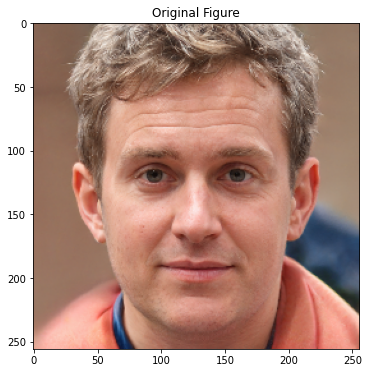

In [ ]:
img = Image.open(r'/content/drive/MyDrive/Datasets/data256/train/train_512679569082.png')
img_arr = np.asarray(img)
fig,ax = plt.subplots(figsize=(6,6))
ax.imshow(img_arr)
ax.set_title('Original Figure')

# Horizontal/Vertical Flip


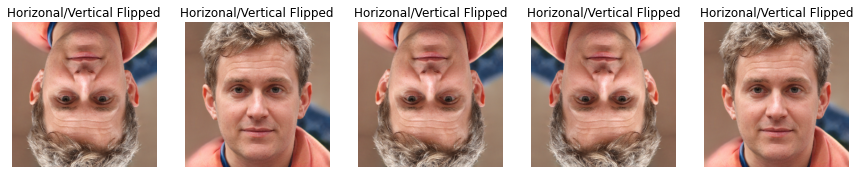

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            horizontal_flip = True,
            vertical_flip = True,
            fill_mode = 'nearest')
aug_iter = datagen.flow(np.expand_dims(img_arr,axis=0), batch_size=1)

fig, ax = plt.subplots(nrows=1,ncols=5,figsize=(15,15))
# generate batch of images
for i in range(5):
    image = next(aug_iter)[0].astype('uint8')
    ax[i].imshow(image)
    ax[i].axis('off')
    ax[i].set_title('Horizonal/Vertical Flipped')

# Horizontal/Vertical Shift

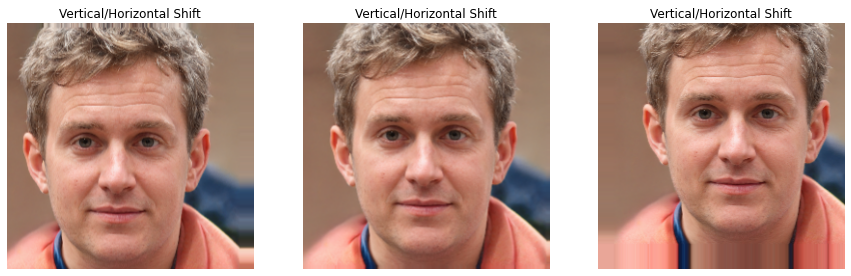

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            width_shift_range=0.1, 
            height_shift_range=0.1,
            fill_mode = 'nearest')
aug_iter = datagen.flow(np.expand_dims(img_arr,axis=0), batch_size=1)

fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(15,15))
# generate batch of images
for i in range(3):
    image = next(aug_iter)[0].astype('uint8')
    ax[i].imshow(image)
    ax[i].axis('off')
    ax[i].set_title('Vertical/Horizontal Shift')

# Rotation

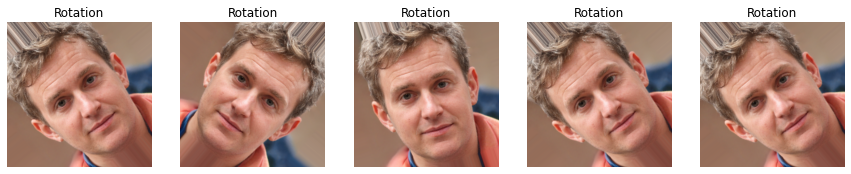

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range = 45,
            fill_mode = 'nearest')
aug_iter = datagen.flow(np.expand_dims(img_arr,axis=0), batch_size=1)

fig, ax = plt.subplots(nrows=1,ncols=5,figsize=(15,15))
# generate batch of images
for i in range(5):
    image = next(aug_iter)[0].astype('uint8')
    ax[i].imshow(image)
    ax[i].axis('off')
    ax[i].set_title('Rotation')

bị lỗi

# Brightness

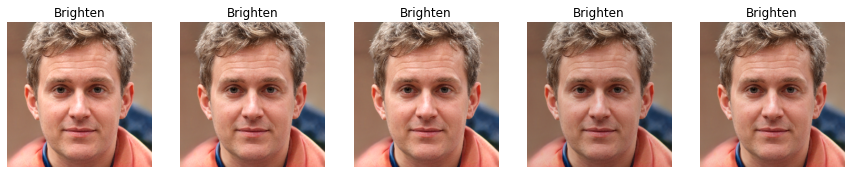

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            brightness_range = [0.8,1.1],
            fill_mode = 'nearest')
aug_iter = datagen.flow(np.expand_dims(img_arr,axis=0), batch_size=1)

fig, ax = plt.subplots(nrows=1,ncols=5,figsize=(15,15))
# generate batch of images
for i in range(5):
    image = next(aug_iter)[0].astype('uint8')
    ax[i].imshow(image)
    ax[i].axis('off')
    ax[i].set_title('Brighten')

Thử xem có ảnh hưởng gì đến những bức hình tối không

Text(0.5, 1.0, 'Original Figure')

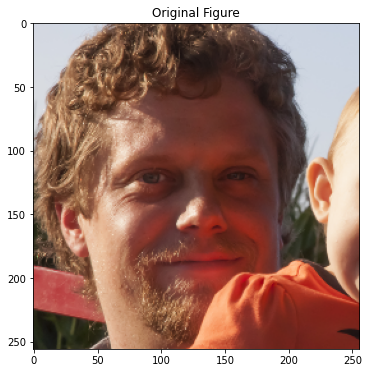

In [ ]:
img2 = Image.open(r'/content/drive/MyDrive/Datasets/data256/train/train_2849758460990.png')
img2_arr = np.asarray(img2)
fig,ax = plt.subplots(figsize=(6,6))
ax.imshow(img2_arr)
ax.set_title('Original Figure')

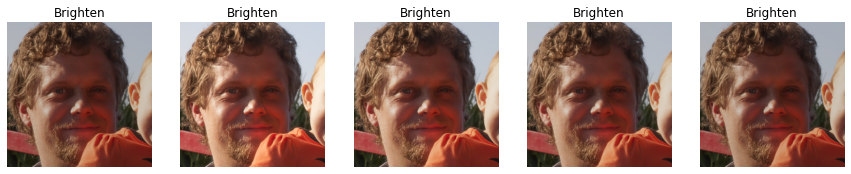

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            brightness_range = [0.8,1.1],
            fill_mode = 'nearest')
aug_iter = datagen.flow(np.expand_dims(img2_arr,axis=0), batch_size=1)

fig, ax = plt.subplots(nrows=1,ncols=5,figsize=(15,15))
# generate batch of images
for i in range(5):
    image = next(aug_iter)[0].astype('uint8')
    ax[i].imshow(image)
    ax[i].axis('off')
    ax[i].set_title('Brighten')

# Zoom

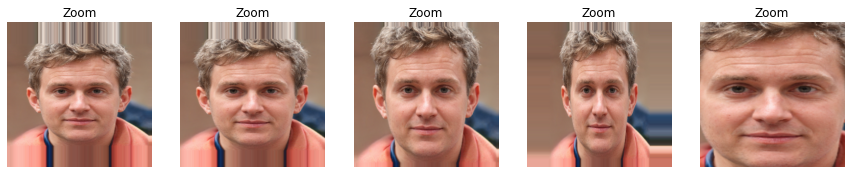

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            zoom_range = [0.5,1.5],
            fill_mode = 'nearest')
aug_iter = datagen.flow(np.expand_dims(img_arr,axis=0), batch_size=1)

fig, ax = plt.subplots(nrows=1,ncols=5,figsize=(15,15))
# generate batch of images
for i in range(5):
    image = next(aug_iter)[0].astype('uint8')
    ax[i].imshow(image)
    ax[i].axis('off')
    ax[i].set_title('Zoom')

No pls

# Data Preparation

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(df_train.drop(columns='label',axis=1),
                                               df_train['label'],
                                               test_size=0.2,
                                               shuffle=True,
                                               random_state=42)
#Giảm số lưọng x_train và x_val
'''x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                               test_size=0.2,
                                               shuffle=True,
                                               random_state=42)'''
df_train_cut = pd.concat([x_train,y_train],axis=1)
df_val_cut = pd.concat([x_val,y_val],axis=1)
print(x_train.shape, x_val.shape)

(6400, 1) (1600, 1)


In [ ]:
def DataGeneration(Height, Width, BatchSize):
    start_time = time.time()
    training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rescale = 1./255,
                horizontal_flip = True,
                vertical_flip = True,
                brightness_range = [0.8,1.5],
                fill_mode = 'nearest')
    train_generator = training_datagen.flow_from_dataframe(
            dataframe = df_train_cut,
            directory = data_PATH,
            x_col = "name",
            y_col = "label",
            target_size = (Height, Width),
            batch_size = BatchSize,
            class_mode = 'binary',
            shuffle = True,
            seed = 42)

    validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rescale = 1./255)
    val_generator = validation_datagen.flow_from_dataframe(
            dataframe = df_val_cut,
            directory = data_PATH,
            x_col = "name",
            y_col = "label",
            target_size = (Height, Width),
            batch_size = BATCH_SIZE,
            class_mode = 'binary',
            shuffle = True,
            seed = 42)

    print(f'----{time.time()-start_time} seconds----')
    return train_generator, val_generator

In [ ]:
def scheduler(epoch):
    if epoch<= WARMUP_EPOCH:
        lr = INITIAL_LEARNINGRATE *epoch/WARMUP_EPOCH
    
    else:
        lr = INITIAL_LEARNINGRATE * DECAY_RATE**(epoch-WARMUP_EPOCH)
    
    return lr

# Test CNN

In [ ]:
HEIGHT = 256
WIDTH = 256
BATCH_SIZE = 128

train_generator, val_generator = DataGeneration(Height = HEIGHT, 
                                                Width = WIDTH,
                                                BatchSize = BATCH_SIZE)

Found 6400 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.
----44.59216856956482 seconds----


In [ ]:
train_generator[0][0][0].shape

(256, 256, 3)

In [ ]:
tf.keras.backend.clear_session()

CNN Model from scratch is trained to compare the effects of implementing different real-time image augmentation methods because it is fast to train. Thanks for the professor's starter notebook.

Từng bước thử các loại augmentation vào xem acc nào cao hơn thì lấy aug đó

In [ ]:
EPOCHS = 3
#STEPS_PER_EPOCH = train_generator.n//BATCH_SIZE
STEPS_PER_EPOCH = 50
#VALIDATION_STEPS = val_generator.n//BATCH_SIZE
VALIDATION_STEPS = 25
LEARNING_RATE = 1e-3

model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(HEIGHT, WIDTH, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    
    #tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.BatchNormalization(),
    #tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
dropout (Dropout)            (None, 125, 125, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 123008)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 123008)            0

In [ ]:
model.compile(loss = 'binary_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              metrics = 'accuracy')
monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           min_delta=1e-4, 
                                           patience=10, 
                                           verbose=1, 
                                           mode='min',
                                           restore_best_weights=True)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                    factor=0.2,
                                                    patience=5,
                                                    verbose=1,
                                                    mode='min',
                                                    min_delta=1e-4,
                                                    cooldown=0,
                                                    min_lr=1e-5,)

checkpoint = tf.keras.callbacks.ModelCheckpoint('CNN_best_weight.h5', 
                                                monitor='val_loss', 
                                                verbose=1, 
                                                save_best_only=True, 
                                                save_weights_only=True, 
                                                mode='min',
                                                save_freq = 'epoch')

history = model.fit(train_generator, 
                    epochs=EPOCHS, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    validation_data = val_generator, 
                    verbose = 1, 
                    validation_steps=VALIDATION_STEPS,
                    callbacks = [monitor,lr_scheduler,checkpoint])

Epoch 1/3
50/50 [==============================] - 1498s 29s/step - loss: 5.0375 - accuracy: 0.5517 - val_loss: 0.5995 - val_accuracy: 0.8388

Epoch 00001: val_loss improved from inf to 0.59950, saving model to CNN_best_weight.h5


horizontal_flip +
vertical_flip +
brightness_range

- val_acc: 0.8388 val_loss: 0.5995 

# Pre-trained model

In [ ]:
def BuildModel(ModelName):
    print('--------------Building The Model...--------------')
    if ModelName == 'ResNet152' or ModelName == 'Xception':
        if ModelName == 'ResNet152':
            base_model = tf.keras.applications.ResNet152(include_top=False,
                                                    weights='imagenet',
                                                    input_shape=(HEIGHT,WIDTH,3))
        
        elif ModelName == 'Xception':
            base_model = tf.keras.applications.Xception(include_top=False,
                                                weights='imagenet',
                                                input_shape=(HEIGHT,WIDTH,3))
        
        base_model.trainable = True
        print("\nNumber of layers in the base model: ", len(base_model.layers))
        #print(base_model.layers[0].output_shape)
        x = base_model.output
        #x = tf.keras.layers.GlobalMaxPooling2D()(x)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(1024,activation='relu')(x)
        x = tf.keras.layers.Dense(512,activation='relu')(x)
        x = tf.keras.layers.Dense(64,activation='relu')(x)
        out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        model = tf.keras.models.Model(inputs=base_model.input, outputs=out)
    
    elif ModelName == 'EfficientNetB7':
        base_model = tf.keras.applications.EfficientNetB7(include_top=False,
                                                weights='imagenet',
                                                input_shape=(HEIGHT,WIDTH,3))
        base_model.trainable = True
        print("\nNumber of layers in the base model: ", len(base_model.layers))
        #print(base_model.layers[0].output_shape)
        x = base_model.output
        #x = tf.keras.layers.GlobalMaxPooling2D()(x)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(1536,activation='relu')(x)
        x = tf.keras.layers.Dense(1024,activation='relu')(x)
        x = tf.keras.layers.Dense(512,activation='relu')(x)
        x = tf.keras.layers.Dense(64,activation='relu')(x)
        out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
        model = tf.keras.models.Model(inputs=base_model.input, outputs=out)
    
    print('\n--------------Done!--------------')
    return model

In [ ]:
def ModelDeployment(model, LearningRate, ModelName,  NbOfEpoch, StepsPerEpoch, ValidationSteps):
    ## Freeze all the layers before the `fine_tune_at` layer
    #for layer in base_model.layers[:fine_tune_at]:
    #    layer.trainable =  False
    print('--------------Deploying the Model...--------------')
    model.compile(loss = 'binary_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LearningRate),
                  metrics = 'accuracy')
    monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                               min_delta=1e-4, 
                                               patience=10, 
                                               verbose=1, 
                                               mode='min',
                                               restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                        factor=0.5,
                                                        patience=3,
                                                        verbose=1,
                                                        mode='min',
                                                        min_delta=1e-4,
                                                        cooldown=0,
                                                        min_lr=MIN_LR,)

    filepath= ModelName+"-{epoch:02d}-{val_loss:.4f}.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, 
                                                    monitor='val_loss', 
                                                    verbose=1, 
                                                    save_best_only=False, 
                                                    save_weights_only=True, 
                                                    mode='min',
                                                    save_freq = 'epoch')
    print('--------------Deployed Successfully--------------')
    print('--------------Training Begins--------------')
    history = model.fit(train_generator, 
                            epochs = NbOfEpoch, 
                            steps_per_epoch = StepsPerEpoch, 
                            validation_data = val_generator, 
                            verbose = 1, 
                            validation_steps = ValidationSteps,
                            callbacks = [monitor,lr_scheduler,checkpoint])
    return history

In [ ]:
def HistoryPlotting(history):
    fig,ax = plt.subplots(figsize=(8,5))
    ax.plot(history.history['loss'],label='train',color='blue')
    ax.plot(history.history['val_loss'],label='val',color='green')
    ax.set_title('model loss',fontsize=14)
    ax.set_ylabel('loss')
    ax.set_xlabel('epoch')
    ax.legend(loc='upper right',fontsize=13)

# ResNet152

In [ ]:
HEIGHT = 256
WIDTH = 256
BATCH_SIZE = 96

train_generator, val_generator = DataGeneration(Height = HEIGHT, 
                                                Width = WIDTH,
                                                BatchSize = BATCH_SIZE)

Found 6400 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.
----1.5938692092895508 seconds----


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
Resnet_based_model = BuildModel(ModelName='ResNet152')
Resnet_based_model.summary()

--------------Building The Model...--------------
234700800/234698864 [==============================] - 3s 0us/step

Number of layers in the base model:  515

--------------Done!--------------
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________

In [ ]:
STEPS_PER_EPOCH = train_generator.n//BATCH_SIZE
#STEPS_PER_EPOCH = 200
VALIDATION_STEPS = val_generator.n//BATCH_SIZE
#VALIDATION_STEPS = 50
LEARNING_RATE = 1e-5
NB_EPOCH = 50
#FINETUNE_LEARNING_RATE = LEARNING_RATE/10
MIN_LR = 1e-8 
#fine_tune_at = 200
Resnet50_history = ModelDeployment(model = Resnet_based_model, 
                                   LearningRate = LEARNING_RATE, 
                                   ModelName = 'ResNet152',  
                                   NbOfEpoch = NB_EPOCH, 
                                   StepsPerEpoch = STEPS_PER_EPOCH, 
                                   ValidationSteps = VALIDATION_STEPS)

--------------Deploying the Model...--------------
--------------Deployed Successfully--------------
--------------Training Begins--------------
Epoch 1/50
200/200 [==============================] - 1622s 8s/step - loss: 0.3867 - accuracy: 0.8532 - val_loss: 1.5641 - val_accuracy: 0.4888

Epoch 00001: saving model to ResNet152-01-1.5641.hdf5
Epoch 2/50
200/200 [==============================] - 458s 2s/step - loss: 0.0615 - accuracy: 0.9797 - val_loss: 3.0011 - val_accuracy: 0.4888

Epoch 00002: saving model to ResNet152-02-3.0011.hdf5
Epoch 3/50
200/200 [==============================] - 458s 2s/step - loss: 0.0356 - accuracy: 0.9878 - val_loss: 3.5602 - val_accuracy: 0.4888

Epoch 00003: saving model to ResNet152-03-3.5602.hdf5
Epoch 4/50
200/200 [==============================] - 458s 2s/step - loss: 0.0259 - accuracy: 0.9919 - val_loss: 1.7994 - val_accuracy: 0.5581

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.

Epoch 00004: saving model to ResNet

KeyboardInterrupt: ignored

# Xception

In [ ]:
HEIGHT = 256
WIDTH = 256
BATCH_SIZE = 16

train_generator, val_generator = DataGeneration(Height = HEIGHT, 
                                                Width = WIDTH,
                                                BatchSize = BATCH_SIZE)

Found 6400 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.
----59.17543840408325 seconds----


In [ ]:
Xception_based_model = BuildModel(ModelName='Xception')
Xception_based_model.summary()

--------------Building The Model...--------------
83689472/83683744 [==============================] - 1s 0us/step

Number of layers in the base model:  132

--------------Done!--------------
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
b

In [ ]:
STEPS_PER_EPOCH = train_generator.n//BATCH_SIZE
#STEPS_PER_EPOCH = 200
VALIDATION_STEPS = val_generator.n//BATCH_SIZE
#VALIDATION_STEPS = 50
LEARNING_RATE = 1e-5
NB_EPOCH = 50
MIN_LR = 1e-8 

Xception_history = ModelDeployment(model = Xception_based_model, 
                                   LearningRate = LEARNING_RATE, 
                                   ModelName = 'Xception',  
                                   NbOfEpoch = NB_EPOCH, 
                                   StepsPerEpoch = STEPS_PER_EPOCH, 
                                   ValidationSteps = VALIDATION_STEPS)

--------------Deploying the Model...--------------
--------------Deployed Successfully--------------
--------------Training Begins--------------
Epoch 1/50
400/400 [==============================] - 2823s 7s/step - loss: 0.4763 - accuracy: 0.7853 - val_loss: 0.1204 - val_accuracy: 0.9625

Epoch 00001: saving model to Xception-01-0.1204.hdf5
Epoch 2/50
400/400 [==============================] - 170s 426ms/step - loss: 0.1461 - accuracy: 0.9454 - val_loss: 0.0699 - val_accuracy: 0.9769

Epoch 00002: saving model to Xception-02-0.0699.hdf5
Epoch 3/50
400/400 [==============================] - 174s 434ms/step - loss: 0.0977 - accuracy: 0.9643 - val_loss: 0.0571 - val_accuracy: 0.9806

Epoch 00003: saving model to Xception-03-0.0571.hdf5
Epoch 4/50
400/400 [==============================] - 174s 435ms/step - loss: 0.0796 - accuracy: 0.9711 - val_loss: 0.0413 - val_accuracy: 0.9844

Epoch 00004: saving model to Xception-04-0.0413.hdf5
Epoch 5/50
400/400 [==============================] - 174

KeyboardInterrupt: ignored

Bị overfit ròii

# EfficientNetB7

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
HEIGHT = 256
WIDTH = 256
BATCH_SIZE = 16

train_generator, val_generator = DataGeneration(Height = HEIGHT, 
                                                Width = WIDTH,
                                                BatchSize = BATCH_SIZE)

Found 6400 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.
----1.5534088611602783 seconds----


In [ ]:
EfficientNet_based_model = BuildModel(ModelName='EfficientNetB7')
EfficientNet_based_model.summary()

--------------Building The Model...--------------
258080768/258076736 [==============================] - 3s 0us/step

Number of layers in the base model:  813

--------------Done!--------------
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 256, 256, 3)  7           rescaling[0][0]                  
________________________________________________________________________________________________

In [ ]:
STEPS_PER_EPOCH = train_generator.n//BATCH_SIZE
#STEPS_PER_EPOCH = 200
VALIDATION_STEPS = val_generator.n//BATCH_SIZE
#VALIDATION_STEPS = 50
LEARNING_RATE = 1e-5
MIN_LR = 1e-8 
NB_EPOCH = 50

EfficientNet_history = ModelDeployment(model = EfficientNet_based_model, 
                                   LearningRate = LEARNING_RATE, 
                                   ModelName = 'EfficientNetB7',  
                                   NbOfEpoch = NB_EPOCH, 
                                   StepsPerEpoch = STEPS_PER_EPOCH, 
                                   ValidationSteps = VALIDATION_STEPS)

--------------Deploying the Model...--------------
--------------Deployed Successfully--------------
--------------Training Begins--------------
Epoch 1/50
800/800 [==============================] - 2072s 3s/step - loss: 0.5101 - accuracy: 0.7551 - val_loss: 0.1934 - val_accuracy: 0.9481

Epoch 00001: saving model to EfficientNetB7-01-0.1934.hdf5
Epoch 2/50
800/800 [==============================] - 533s 666ms/step - loss: 0.1955 - accuracy: 0.9244 - val_loss: 0.1034 - val_accuracy: 0.9706

Epoch 00002: saving model to EfficientNetB7-02-0.1034.hdf5
Epoch 3/50
800/800 [==============================] - 535s 668ms/step - loss: 0.1439 - accuracy: 0.9471 - val_loss: 0.0790 - val_accuracy: 0.9769

Epoch 00003: saving model to EfficientNetB7-03-0.0790.hdf5
Epoch 4/50
800/800 [==============================] - 533s 666ms/step - loss: 0.0860 - accuracy: 0.9693 - val_loss: 0.0489 - val_accuracy: 0.9850

Epoch 00004: saving model to EfficientNetB7-04-0.0489.hdf5
Epoch 5/50
800/800 [=============

KeyboardInterrupt: ignored

# Predict


In [ ]:
from keras.models import load_model

weights_path = '/content/drive/MyDrive/Models/AIIJC/ResNet152-21-0.0109.hdf5'

model = Resnet_based_model
model.load_weights(weights_path)

Text(0.5, 1.0, 'Original Figure')

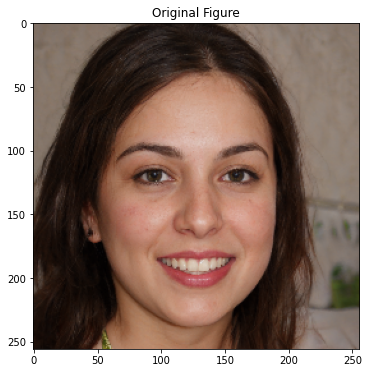

In [ ]:
img = Image.open(r'/content/drive/MyDrive/Datasets/data256/test/test_100071345206782.png')
img_arr = np.asarray(img)
fig,ax = plt.subplots(figsize=(6,6))
ax.imshow(img_arr)
ax.set_title('Original Figure')

In [ ]:
pic = '/content/drive/MyDrive/Datasets/data256/test/test_100071345206782.png'
#model = load_model('/content/weights-24.hdf5')
X = []
X.append(cv2.resize(cv2.imread(pic),dsize=(256,256)))
X = np.array(X)
X = X/255
predictions = model.predict(X)
print(predictions)

[[0.99962926]]


In [ ]:
start_time = time.time()
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale = 1./255)
test_generator = test_datagen.flow_from_dataframe(
        dataframe = df_test,
        directory = '/content/drive/MyDrive/Datasets/data256/test',
        x_col="name",
        target_size = (HEIGHT, WIDTH),
        batch_size = 1,
        shuffle = False,
        class_mode = None)
print(f'----{time.time()-start_time} seconds----')
## very important
test_generator.reset()

Found 12000 validated image filenames.
----5.6816465854644775 seconds----


In [ ]:
pred = Resnet_based_model.predict(test_generator,steps=len(df_test))

In [ ]:
print(pred[0])

In [ ]:
df_submit = pd.DataFrame({"name":df_test['name'],'pred':pred.flatten()})
df_submit.to_csv("submision.csv",index = False)
df_submit.head(20)

,name,pred
0,test_1000183618656797.png,0.999995
1,test_1000393965653244.png,0.998744
2,test_100071345206782.png,0.999998
3,test_100100998368010.png,0.000378
4,test_1001897299647728.png,0.999665
5,test_1002185713934821.png,0.996801
6,test_1003087301733830.png,0.001139
7,test_1004381477443244.png,0.003213
8,test_1004793951488314.png,0.007825
9,test_1005172244305045.png,0.000801


# Ensemble


In [ ]:
Resnet_based_model = BuildModel(ModelName='ResNet152')
EfficientNet_based_model = BuildModel(ModelName='EfficientNetB7')
Resnet_based_model.load_weights('/content/drive/MyDrive/Models/ResNet152-16-0.0092.hdf5')
EfficientNet_based_model.load_weights('/content/drive/MyDrive/Models/EfficientNetB7-11-0.0150.hdf5')

--------------Building The Model...--------------

Number of layers in the base model:  515

--------------Done!--------------
--------------Building The Model...--------------

Number of layers in the base model:  813

--------------Done!--------------


In [ ]:
Resnet_val_pred = Resnet_based_model.predict(val_generator, steps=len(df_val_cut)//16)
EfficientNet_val_pred = EfficientNet_based_model.predict(val_generator, steps=len(df_val_cut)/16)

In [ ]:
val_y = df_val_cut['label'].astype(np.float32).values

Resnet_val_logloss = log_loss(val_y, Resnet_val_pred.flatten())
EfficientNet_val_logloss = log_loss(val_y, EfficientNet_val_pred.flatten())
print(f'Before Clipping,\nResnet_Logloss: {Resnet_val_logloss}\nEfficientNet_Logloss: {EfficientNet_val_logloss}')

Before Clipping,
Resnet_Logloss: 5.398619905631335
EfficientNet_Logloss: nan


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: divide by zero encountered in log
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:2295: RuntimeWarning: invalid value encountered in multiply
  loss = -(transformed_labels * np.log(y_pred)).sum(axis=1)


In [ ]:
ensemble_pred_1 = 0.4*Resnet_val_pred + 0.6*EfficientNet_val_pred
print(f'Before Clipping, Blending_Logloss: {log_loss(val_y,ensemble_pred_1)}')

Before Clipping, Blending_Logloss: 2.2087216108137593


In [ ]:
clipped_ensemble_pred_1 = np.clip(ensemble_pred_1,0.03,0.97)
print(f'After Clipping, Blending_Logloss: {log_loss(val_y,clipped_ensemble_pred_1)}')

After Clipping, Blending_Logloss: 1.1744156735343858


Clipping + Blending

In [ ]:
Resnet_clipped_val_pred = np.clip(Resnet_val_pred.flatten(),0.04,0.96)
EfficientNet_clipped_val_pred = np.clip(EfficientNet_val_pred.flatten(),0.04,0.96)

Resnet_val_logloss = log_loss(val_y,Resnet_clipped_val_pred)
EfficientNet_val_logloss = log_loss(val_y,EfficientNet_clipped_val_pred)
print(f'After Clipping,\nResnet_Logloss: {Resnet_val_logloss}\nEfficientNet_Logloss: {EfficientNet_val_logloss}')

After Clipping,
Resnet_Logloss: 1.5789705359586514
EfficientNet_Logloss: 1.5578644901141525


In [ ]:
ensemble_pred_2 = 0.5*Resnet_clipped_val_pred + 0.5*EfficientNet_clipped_val_pred
#ensemble_pred_2 = (Resnet_clipped_val_pred + Xception_clipped_val_pred + EfficientNet_clipped_val_pred)/3
log_loss(val_y,ensemble_pred_2)

1.1019701635488308

In [ ]:
#ResNet pred
import csv
Resnet_pred = []
EfficientNet_pred = []

with open(r'/content/drive/MyDrive/Models/AIIJC/submision.csv') as f1:
  csv_reader = csv.reader(f1)
  k = 0
  for row in csv_reader:
    if k == 0:
      pass
    if k != 0:
      Resnet_pred.append(float(row[1]))
      k = k+1
    k = k+1

with open(r'/content/drive/MyDrive/Models/AIIJC/submision (1).csv') as f2:
  csv_reader = csv.reader(f2)
  k = 0
  for row in csv_reader:
    if k == 0:
      pass
    if k != 0:
      EfficientNet_pred.append(float(row[1]))
    k = k+1

In [ ]:
Resnet_pred = np.array(Resnet_pred)
EfficientNet_pred = np.array(EfficientNet_pred)

In [ ]:
Resnet_clipped_pred = np.clip(Resnet_pred.flatten(),0.04,0.96)
EfficientNet_clipped_pred = np.clip(EfficientNet_pred.flatten(),0.04,0.96)

ensemble_pred = 0.5*Resnet_clipped_pred + 0.5*EfficientNet_clipped_pred

In [ ]:
ensemble_pred = 0.4*Resnet_pred + 0.6*EfficientNet_pred
clipped_ensemble_pred = np.clip(ensemble_pred,0.03,0.97)

In [ ]:
ensemble_pred.shape

(12000,)

In [ ]:
df_submit = pd.DataFrame({"name":df_test['name'],'pred':ensemble_pred.flatten()})
df_submit.to_csv("submision.csv",index = False)
df_submit.head(20)

,name,pred
0,test_1000183618656797.png,0.999975
1,test_1000393965653244.png,0.995645
2,test_100071345206782.png,0.999998
3,test_100100998368010.png,0.000027
4,test_1001897299647728.png,0.999747
5,test_1002185713934821.png,0.989483
6,test_1003087301733830.png,0.000072
7,test_1004381477443244.png,0.000866
8,test_1004793951488314.png,0.001464
9,test_1005172244305045.png,0.000191
